#### Import data and librarys

In [98]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [95]:
df = pd.read_csv("agg.csv")

#### Model

In [108]:
df["updated_at"] = pd.to_datetime(df["updated_at"])
df = df.sort_values(["number", "updated_at"])
df["ratio"] = df["available_to_total_ratio"].astype(float)
df["hour"] = df["updated_at"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["minute"] = df["updated_at"].dt.minute
df["weekday_num"] = df["updated_at"].dt.weekday
df["is_weekend"] = (df["is_weekend"].astype(str).str.strip().str.lower().replace({"false": 0, "true": 1}))
df["is_weekend"] = df["is_weekend"].fillna(0)
df["is_weekend"] = df["is_weekend"].astype(int)

In [97]:
scaler = StandardScaler()
df["ratio_norm"] = scaler.fit_transform(df[["ratio"]])


In [ ]:
SEQ_LEN = 144 

def build_sequences(group):
    X, y = [], []
    data = group[["ratio_norm", "hour_sin", "hour_cos", "weekday_num", "is_weekend"]].values
    for i in range(len(data) - SEQ_LEN):
        X.append(data[i:i+SEQ_LEN])
        y.append(data[i+SEQ_LEN][0])  
    return np.array(X), np.array(y)

X_list, y_list = [], []

for station_id, g in df.groupby("number"):
    Xi, yi = build_sequences(g)
    X_list.append(Xi)
    y_list.append(yi)

X = np.vstack(X_list)
y = np.concatenate(y_list)

split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [118]:
class BikeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = BikeDataset(X_train, y_train)
val_ds = BikeDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


In [119]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        output, _ = self.gru(x)
        last = output[:, -1, :]
        return self.fc(last)

model = GRUModel(input_dim=X.shape[2], hidden_dim=128)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training

In [120]:
for epoch in range(20):
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb).squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            pred = model(Xb).squeeze()
            val_loss += criterion(pred, yb).item()
    
    print(f"Epoch {epoch}: train {train_loss:.4f}, val {val_loss:.4f}")


Epoch 0: train 24.2784, val 4.4058
Epoch 1: train 16.3639, val 4.3335
Epoch 2: train 16.1422, val 4.3757
Epoch 3: train 16.0312, val 4.2567
Epoch 4: train 15.9628, val 4.2219
Epoch 5: train 15.8940, val 4.1642
Epoch 6: train 15.8453, val 4.1486
Epoch 7: train 15.7566, val 4.1515
Epoch 8: train 15.6990, val 4.1322
Epoch 9: train 15.6698, val 4.1343
Epoch 10: train 15.5649, val 4.1466
Epoch 11: train 15.5651, val 4.1721
Epoch 12: train 15.5127, val 4.1268
Epoch 13: train 15.5124, val 4.0915
Epoch 14: train 15.4182, val 4.1331
Epoch 15: train 15.4330, val 4.1950
Epoch 16: train 15.3469, val 4.1077
Epoch 17: train 15.3054, val 4.1120
Epoch 18: train 15.2773, val 4.1555
Epoch 19: train 15.2414, val 4.2313


#### Use historical data to predict the next 24 hours

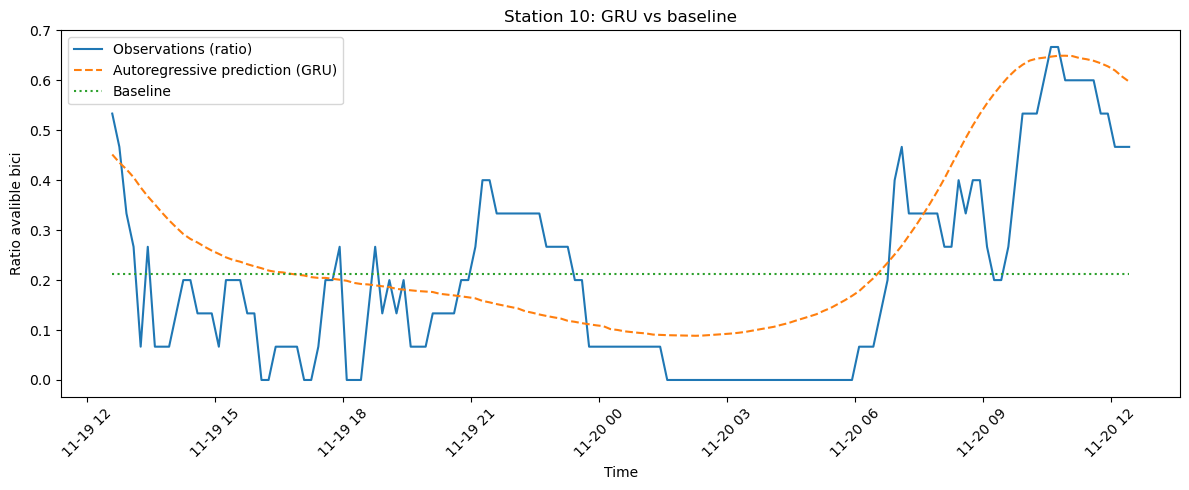

In [156]:
station = 10
df1 = df[df["number"] == station].copy()
df1 = df1.sort_values("updated_at")

last_ts = df1["updated_at"].max()
cutoff = last_ts - pd.Timedelta(hours=24)

df_hist = df1[df1["updated_at"] < cutoff].copy()     
df_future = df1[df1["updated_at"] >= cutoff].copy() 

features = ["ratio_norm", "hour_sin", "hour_cos", "weekday_num", "is_weekend"]
hist_vals = df_hist[features].values
X_window = hist_vals[-SEQ_LEN:].copy()    
X_window = torch.tensor(X_window, dtype=torch.float32).unsqueeze(0)

preds = []

baseline_ratio = df_hist["ratio"].mean()
baseline_preds_ratio = np.ones(len(df_future)) * baseline_ratio

model.eval()
with torch.no_grad():
    for i in range(len(df_future)):

        pred_norm = model(X_window).numpy().flatten()[0]
        preds.append(pred_norm)

        next_feat = np.array([
            pred_norm,
            df_future.iloc[i]["hour_sin"],
            df_future.iloc[i]["hour_cos"],
            df_future.iloc[i]["weekday_num"],
            df_future.iloc[i]["is_weekend"]
        ], dtype=float)

        next_feat = torch.tensor(next_feat, dtype=torch.float32)

        X_window = torch.cat([X_window[:, 1:, :], next_feat.view(1, 1, -1)], dim=1)

preds_ratio = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

true_ratio = df_future["ratio"].values[:len(preds_ratio)]
times = df_future["updated_at"].values[:len(preds_ratio)]

plt.figure(figsize=(12,5))
plt.plot(times, true_ratio, label="Observations (ratio)")
plt.plot(times, preds_ratio, label="Autoregressive prediction (GRU)", linestyle="--")
plt.plot(times, baseline_preds_ratio, label="Baseline", linestyle=":")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Ratio avalible bici")
plt.title(f"Station {station}: GRU vs baseline")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

true_arr = np.array(true_ratio)
pred_arr = np.array(preds_ratio)

mae = mean_absolute_error(true_arr, pred_arr)
rmse = mean_squared_error(true_arr, pred_arr, squared=False)
r2 = r2_score(true_arr, pred_arr)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


MAE:  0.1356
RMSE: 0.1470
R²:   -0.7015
